In [1]:
import numpy as np
import lmfit
from lmfit.models import VoigtModel
from lmfit.models import LinearModel
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Times New Roman'
# mpl.style.use('seaborn-colorblind') # colourblind-friendly colour scheme

from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings("ignore")


filepath = '/Users/katelynsmith/Desktop/spectra/LSDresultsV2/Normalised_LSD/'
spectras = ['2811714V2', '2811876V2', '2812052V2', '2812217V2', '2812495V2', '2812675V2', '2812884V2', '2813059V2', '2813220V2', '2813436V2', '2813529V2', '2838891V2', '2838899V2', '2839172V2', '2839366V2', '2839532V2', '2839709V2', '2839889V2', '2840072V2']


In [2]:
# accessing individual rows and values
# noting that the second column should host the Stokes I values and the first the radial velocity values

# function for obtaining Stokes I values
def getStokesI(dir, spectra: list, num_files, rows = 266, StokesIPosition = 1):
    # defining an empty matrix to store all the Stokes I values
    all_Stokes_I = np.zeros((rows, num_files))
    # reading in the data
    for n in range(num_files):
        with open(dir + spectra[n] + '.dat.norm', 'r') as file:
            content = file.read()

        subcontent = content.split('\n')
        
        # rows should start at 2 and go to the length of the datafile to avoid the header info
        # looping over the rows in the data files
        for r in range(2, rows):
            # splitting the data into individual values
            data_rows = subcontent[r].split(' ')
            data_rows[:] = [x for x in data_rows if x]
            Stokes_I = float(data_rows[StokesIPosition])
            # storing the Stokes I values in the matrix
            all_Stokes_I[r-2][n] = Stokes_I
    return all_Stokes_I


# function for obtaining radial velocity values
def getVelocity(dir, spectra: list, num_files, rows = 266, VelocityPosition = 0):
    # defining an empty matrix to store all the velocity values
    all_Velocities = np.zeros((rows, num_files))
    # reading in the data
    for n in range(num_files):
        with open(dir + spectra[n] + '.dat.norm', 'r') as file:
            content = file.read()

        subcontent = content.split('\n')
        
        # rows should start at 2 and go to the length of the datafile to avoid the header info
        # looping over the rows in the data files
        for r in range(2, rows):
            # splitting the data into individual values
            data_rows = subcontent[r].split(' ')
            data_rows[:] = [x for x in data_rows if x]
            Velocity = float(data_rows[VelocityPosition])
            # storing the velocity values in the matrix
            all_Velocities[r-2][n] = Velocity
    return all_Velocities

In [3]:
# isolating data with use of above functions
SI = getStokesI(filepath, spectras, 18)
vel = getVelocity(filepath, spectras, 18)

In [52]:
# pulling out individual columns of Stokes I data (noting the [:-2] takes all of the elements but the last two which are simply stray zeroes)
velocity = vel[:-2,0]
StokesI = SI[:-2,0]


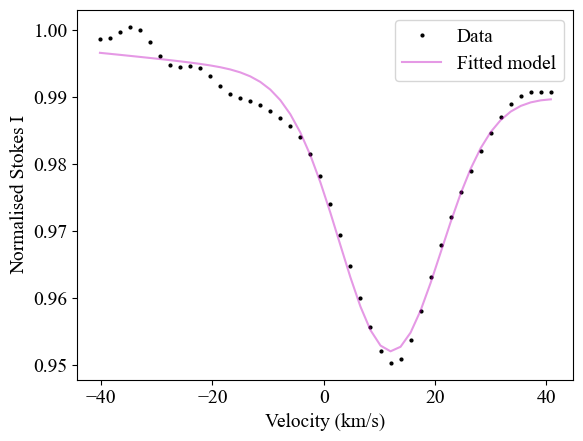

[[Model]]
    (Model(linear) + Model(voigt))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 46
    # variables        = 5
    chi-square         = 1.7966e-04
    reduced chi-square = 4.3819e-06
    Akaike info crit   = -562.842166
    Bayesian info crit = -553.698959
    R-squared          = 0.98227246
[[Variables]]
    slope:     -7.7564e-05 +/- 1.7308e-05 (22.31%) (init = -7.7563e-05)
    intercept:  0.99356537 +/- 5.6200e-04 (0.06%) (init = 0.9935654)
    amplitude: -0.97884613 +/- 0.04017304 (4.10%) (init = -0.9788485)
    center:     11.9393227 +/- 0.24948857 (2.09%) (init = 11.93932)
    sigma:      8.82121565 +/- 0.32304402 (3.66%) (init = 8.821241)
    gamma:      1 (fixed)
    fwhm:       21.8622429 +/- 0.75994146 (3.48%) == '1.0692*gamma+sqrt(0.8664*gamma**2+5.545083*sigma**2)'
    height:    -0.04053267 +/- 9.9568e-04 (2.46%) == '(amplitude/(max(1e-15, sigma*sqrt(2*pi))))*real(wofz((1j*gamma)/(max(1e-15, sigma*sqrt(2)

In [59]:

model = LinearModel() + VoigtModel()
# defining the parameters
params = model.make_params(intercept=0.99356540, slope=-7.7563e-05, amplitude=-0.97884854, center=11.9393168, sigma=8.82124136, gamma=1)

# adjusting velocity range of the data (± 40 km/s)
good_indices = []
for ind, val in enumerate(velocity):
    if (val >= -41 and val <= 41):
        good_indices.append(ind)

adjusted_velocity = velocity[good_indices]
adjusted_StokesI = StokesI[good_indices]



# fitting the model to the data
result = model.fit(adjusted_StokesI, params, x=adjusted_velocity)
# # plotting the data and the model
plt.plot(adjusted_velocity, adjusted_StokesI, 'k.', markersize=4, label='Data')
plt.plot(adjusted_velocity, result.best_fit, 'm-', label='Fitted model', alpha=0.4)
plt.xlabel('Velocity (km/s)')
plt.ylabel('Normalised Stokes I')
plt.legend()
plt.show()
print(result.fit_report())

In [97]:
model_1 = VoigtModel()
model_2 = LinearModel()
full_model = model_2 - model_1
pars = full_model.guess(StokesI, velocity)
fit = full_model.fit(StokesI, pars, velocity)

NotImplementedError: guess() not implemented for CompositeModel

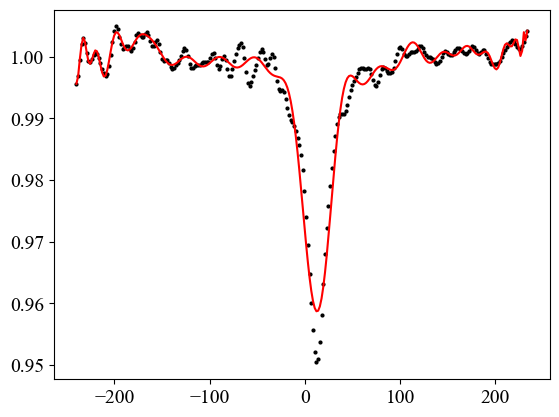

In [85]:
fit = np.poly1d(np.polyfit(velocity, StokesI, 50))

model = fit(velocity)

plt.plot(velocity, StokesI, 'k.', markersize = 4)
plt.plot(velocity, model, 'r-')
plt.show()

In [44]:
spec = ['2811714V2', '2811876V2', '2812052V2', '2812217V2', '2812495V2', '2812675V2', '2812884V2', '2813059V2', '2813220V2', '2813436V2', '2813529V2', '2838891V2', '2838899V2', '2839172V2', '2839366V2', '2839532V2', '2839709V2', '2839889V2', '2840072V2']
dir = '/Users/katelynsmith/Desktop/spectra/LSDresultsV2/Normalised_LSD/'

rows, num_files = 266, 18
StokesI = np.zeros((rows, num_files))
Vel = np.zeros((rows, num_files))

for n in range(num_files):
    with open(dir + spec[n] + '.dat.contin', 'r') as file:
        content = file.read()
    subcontent = content.split('\n')
    for r in range(rows):
        # splitting the data into individual values
        data_rows = subcontent[r].split(' ')
        StokesI[r][n] = data_rows[1]
        Vel[r][n] = data_rows[0]

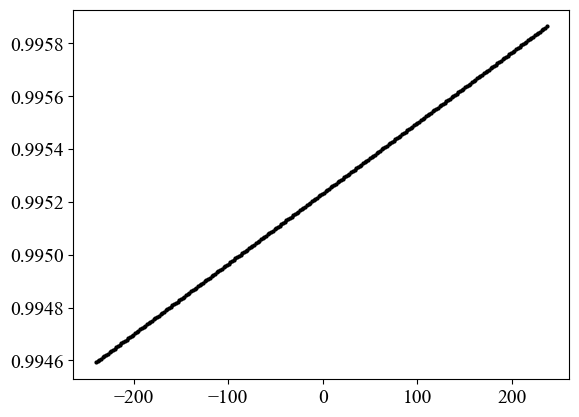

In [53]:
plt.plot(Vel[:,0], StokesI[:,0], 'k.', markersize = 4)
plt.show()
